## Frequency Analysis

Generating a complex pattern (distribution) from a single value can be done with dense layers, conv layer and recurrent layers. Autoencoders and Variational Autoencoders can easily be trained to decode a small latent-space vector into a complex image or waveform.

This document investigates what kinds of networks are best suited to extract the required information needed to re-generate an input waveform.

Ideally, we want a network that performs a component analysis of an input sample, and outputs the frequencies of the sinewaves that it consists of.

In [1]:
from __future__ import division

import keras
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline
# local libs
import config, models, setup
import midi
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [3]:
context = setup.init()

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 10.0 0.5
 >> Context(max_t=2.0, dt=0.05, n_timesteps=40, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  40.000000
 max_f: 10.000000, min_f: 0.500000


In [4]:
n = 10 * 1
dim4 = True
multiTrack = True
x_train, labels = setup.import_data(context, n, dim4=dim4, multiTrack=multiTrack)


Importing midi-data

Encoding midi-data
 10
> -> multi-track = True global
 [INFO] : 
 |  True
 [INFO] : 
 |  reduced mt list dims:
 |  (10, 40, 13)


In [5]:
n = 1000
min_f = 0
max_f = 4
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=1,
    d_phase=False,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  True
 [INFO] : 
 |  reduced mt list dims:
 |  (1000, 40, 1)


In [6]:
params.shape # n, n_channels, n_polyrythms

(1000, 1, 1)

In [7]:
x_train.shape

(1000, 40, 1, 1)

In [8]:
# train test split
m = int(x_train.shape[0] * 0.9)

(array([1., 1., 0., 0., 0., 1., 1., 2., 1., 3.]),
 array([0.48761451, 0.83502664, 1.18243877, 1.5298509 , 1.87726304,
        2.22467517, 2.5720873 , 2.91949943, 3.26691156, 3.61432369,
        3.96173582]),
 <a list of 10 Patch objects>)

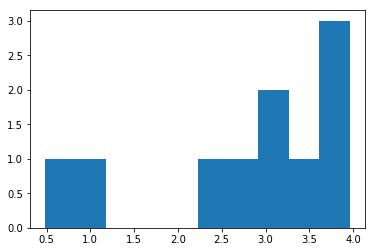

In [9]:
plt.hist(params[:10,0,0])

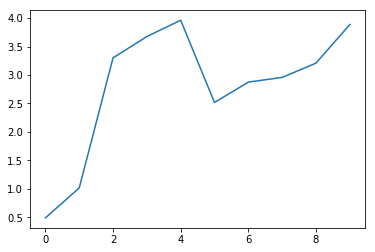

In [10]:
plt.plot(params[:10,0,0])

In [11]:
# range_ = (max_f - min_f)
range_ = max_f + 1 # extra margin = 1
y_train = params[:,0,0] / range_
y_train.shape

(1000,)

In [12]:
x_train.shape

(1000, 40, 1, 1)

In [13]:
x_test = x_train[m:]
x_train = x_train[:m]
y_test = y_train[m:]
y_train = y_train[:m]

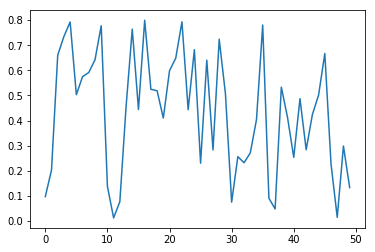

In [14]:
plt.plot(y_train[:50])

m (30, 1)


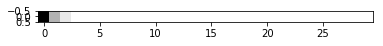

m (30, 1)


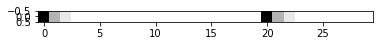

[0.0975229 0.2030567]


In [15]:
i = 0
plot.single(x_train[i,:30,0])
plot.single(x_train[i+1,:30,0])
print(y_train[i:i+2])

Make sure all frequencies fall inside the window

m (30, 1)


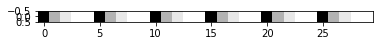

m (30, 1)


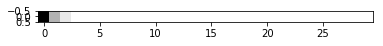

0.7998534611385836 0.0


In [16]:
i = y_train.argmax()
j = y_train.argmin()
plot.single(x_train[i,:30,0])
plot.single(x_train[j,:30,0])
print(y_train[i], y_train[j])

In [17]:
input_shape = x_train[0].shape
input_shape

(40, 1, 1)

In [180]:
timesteps, notes, channels = input_shape

encoder_input = Input(shape=(timesteps, notes, channels))
x = encoder_input

x = Reshape((timesteps, notes))(x)
# x = Reshape((timesteps, notes,1,1))(x)
# x = SimpleRNN(1)(x)
x = SimpleRNN(4, unroll=True)(x)
# x = ConvLSTM2D(3, kernel_size=(1,1))(x)
# x = Flatten()(x)
x = Dense(4, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

encoder_output = x

encoder_model = Model(encoder_input, encoder_output, name='encoder-')
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 40, 1, 1)          0         
_________________________________________________________________
reshape_22 (Reshape)         (None, 40, 1)             0         
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 4)                 24        
_________________________________________________________________
dense_55 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 5         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [181]:
loss = 'mse' # mse mae binary_crossentropy rmsprop adadelta
encoder_model.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','binary_crossentropy'])

In [182]:
phase_mod = 0.1
whitening = False

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
#         zca_epsilon=10,
        zca_whitening=whitening,
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.,  # note-channel mod, but not shuffled
        height_shift_range=phase_mod,  # start_t, phase
        horizontal_flip=False,  # reverse
        vertical_flip=False)

datagen.fit(x_train)

In [183]:
batch_size = 100
epochs = 500

In [184]:
data_augmentation = False
# data_augmentation = True

callbacks = []
# callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

if not data_augmentation:
    print('Not using data augmentation.')
#     history = ae.fit(x_train, epochs=epochs, validation_data=(x_test, None))
    history = encoder_model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        shuffle=True)
else:
    print('Using real-time data augmentation.')    
    history = encoder_model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        workers=4)

Not using data augmentation.
Train on 900 samples, validate on 100 samples
Epoch 1/500
900/900 [==============================] - 1s 2ms/step - loss: 0.0467 - acc: 0.0022 - mean_absolute_error: 0.1817 - binary_crossentropy: 0.6661 - val_loss: 0.0256 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.1407 - val_binary_crossentropy: 0.6039
Epoch 2/500
900/900 [==============================] - 0s 38us/step - loss: 0.0187 - acc: 0.0022 - mean_absolute_error: 0.1187 - binary_crossentropy: 0.6044 - val_loss: 0.0130 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0937 - val_binary_crossentropy: 0.5730
Epoch 3/500
900/900 [==============================] - 0s 47us/step - loss: 0.0114 - acc: 0.0022 - mean_absolute_error: 0.0870 - binary_crossentropy: 0.5866 - val_loss: 0.0106 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0804 - val_binary_crossentropy: 0.5668
Epoch 4/500
900/900 [==============================] - 0s 50us/step - loss: 0.0093 - acc: 0.0022 - mean_absolute_error: 0.0787 -

900/900 [==============================] - 0s 39us/step - loss: 0.0035 - acc: 0.0022 - mean_absolute_error: 0.0483 - binary_crossentropy: 0.5701 - val_loss: 0.0040 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0549 - val_binary_crossentropy: 0.5536
Epoch 32/500
900/900 [==============================] - 0s 37us/step - loss: 0.0034 - acc: 0.0022 - mean_absolute_error: 0.0477 - binary_crossentropy: 0.5697 - val_loss: 0.0041 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0545 - val_binary_crossentropy: 0.5540
Epoch 33/500
900/900 [==============================] - 0s 40us/step - loss: 0.0035 - acc: 0.0022 - mean_absolute_error: 0.0482 - binary_crossentropy: 0.5700 - val_loss: 0.0038 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0537 - val_binary_crossentropy: 0.5530
Epoch 34/500
900/900 [==============================] - 0s 38us/step - loss: 0.0033 - acc: 0.0022 - mean_absolute_error: 0.0468 - binary_crossentropy: 0.5695 - val_loss: 0.0038 - val_acc: 0.0000e+00 - val_mean_ab

Epoch 62/500
900/900 [==============================] - 0s 40us/step - loss: 0.0025 - acc: 0.0022 - mean_absolute_error: 0.0411 - binary_crossentropy: 0.5667 - val_loss: 0.0027 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0448 - val_binary_crossentropy: 0.5492
Epoch 63/500
900/900 [==============================] - 0s 42us/step - loss: 0.0023 - acc: 0.0022 - mean_absolute_error: 0.0393 - binary_crossentropy: 0.5662 - val_loss: 0.0030 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0462 - val_binary_crossentropy: 0.5499
Epoch 64/500
900/900 [==============================] - 0s 36us/step - loss: 0.0022 - acc: 0.0022 - mean_absolute_error: 0.0386 - binary_crossentropy: 0.5659 - val_loss: 0.0026 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0431 - val_binary_crossentropy: 0.5485
Epoch 65/500
900/900 [==============================] - 0s 37us/step - loss: 0.0024 - acc: 0.0022 - mean_absolute_error: 0.0394 - binary_crossentropy: 0.5662 - val_loss: 0.0025 - val_acc: 0.0000e+00 

Epoch 93/500
900/900 [==============================] - 0s 42us/step - loss: 0.0019 - acc: 0.0022 - mean_absolute_error: 0.0355 - binary_crossentropy: 0.5647 - val_loss: 0.0018 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0354 - val_binary_crossentropy: 0.5461
Epoch 94/500
900/900 [==============================] - 0s 40us/step - loss: 0.0020 - acc: 0.0022 - mean_absolute_error: 0.0362 - binary_crossentropy: 0.5648 - val_loss: 0.0023 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0393 - val_binary_crossentropy: 0.5470
Epoch 95/500
900/900 [==============================] - 0s 45us/step - loss: 0.0016 - acc: 0.0022 - mean_absolute_error: 0.0330 - binary_crossentropy: 0.5640 - val_loss: 0.0018 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0356 - val_binary_crossentropy: 0.5460
Epoch 96/500
900/900 [==============================] - 0s 37us/step - loss: 0.0020 - acc: 0.0022 - mean_absolute_error: 0.0360 - binary_crossentropy: 0.5647 - val_loss: 0.0018 - val_acc: 0.0000e+00 

Epoch 124/500
900/900 [==============================] - 0s 40us/step - loss: 0.0019 - acc: 0.0022 - mean_absolute_error: 0.0351 - binary_crossentropy: 0.5644 - val_loss: 0.0015 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0316 - val_binary_crossentropy: 0.5451
Epoch 125/500
900/900 [==============================] - 0s 40us/step - loss: 0.0015 - acc: 0.0022 - mean_absolute_error: 0.0320 - binary_crossentropy: 0.5636 - val_loss: 0.0027 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0413 - val_binary_crossentropy: 0.5475
Epoch 126/500
900/900 [==============================] - 0s 36us/step - loss: 0.0018 - acc: 0.0022 - mean_absolute_error: 0.0343 - binary_crossentropy: 0.5642 - val_loss: 0.0024 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0390 - val_binary_crossentropy: 0.5470
Epoch 127/500
900/900 [==============================] - 0s 43us/step - loss: 0.0018 - acc: 0.0022 - mean_absolute_error: 0.0345 - binary_crossentropy: 0.5642 - val_loss: 0.0017 - val_acc: 0.0000e

900/900 [==============================] - 0s 51us/step - loss: 0.0015 - acc: 0.0022 - mean_absolute_error: 0.0318 - binary_crossentropy: 0.5634 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0297 - val_binary_crossentropy: 0.5445
Epoch 155/500
900/900 [==============================] - 0s 43us/step - loss: 0.0016 - acc: 0.0022 - mean_absolute_error: 0.0326 - binary_crossentropy: 0.5637 - val_loss: 0.0018 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0338 - val_binary_crossentropy: 0.5455
Epoch 156/500
900/900 [==============================] - 0s 43us/step - loss: 0.0016 - acc: 0.0022 - mean_absolute_error: 0.0329 - binary_crossentropy: 0.5637 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0302 - val_binary_crossentropy: 0.5446
Epoch 157/500
900/900 [==============================] - 0s 43us/step - loss: 0.0014 - acc: 0.0022 - mean_absolute_error: 0.0305 - binary_crossentropy: 0.5631 - val_loss: 0.0017 - val_acc: 0.0000e+00 - val_mean

Epoch 185/500
900/900 [==============================] - 0s 42us/step - loss: 0.0015 - acc: 0.0022 - mean_absolute_error: 0.0316 - binary_crossentropy: 0.5634 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0276 - val_binary_crossentropy: 0.5441
Epoch 186/500
900/900 [==============================] - 0s 40us/step - loss: 0.0019 - acc: 0.0022 - mean_absolute_error: 0.0351 - binary_crossentropy: 0.5642 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0290 - val_binary_crossentropy: 0.5443
Epoch 187/500
900/900 [==============================] - 0s 36us/step - loss: 0.0012 - acc: 0.0022 - mean_absolute_error: 0.0275 - binary_crossentropy: 0.5626 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0277 - val_binary_crossentropy: 0.5441
Epoch 188/500
900/900 [==============================] - 0s 36us/step - loss: 0.0015 - acc: 0.0022 - mean_absolute_error: 0.0320 - binary_crossentropy: 0.5634 - val_loss: 0.0012 - val_acc: 0.0000e

900/900 [==============================] - 0s 37us/step - loss: 0.0016 - acc: 0.0022 - mean_absolute_error: 0.0326 - binary_crossentropy: 0.5634 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0269 - val_binary_crossentropy: 0.5439
Epoch 216/500
900/900 [==============================] - 0s 36us/step - loss: 0.0013 - acc: 0.0022 - mean_absolute_error: 0.0292 - binary_crossentropy: 0.5629 - val_loss: 0.0020 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0367 - val_binary_crossentropy: 0.5458
Epoch 217/500
900/900 [==============================] - 0s 33us/step - loss: 0.0016 - acc: 0.0022 - mean_absolute_error: 0.0337 - binary_crossentropy: 0.5636 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0292 - val_binary_crossentropy: 0.5443
Epoch 218/500
900/900 [==============================] - 0s 35us/step - loss: 0.0012 - acc: 0.0022 - mean_absolute_error: 0.0288 - binary_crossentropy: 0.5627 - val_loss: 0.0016 - val_acc: 0.0000e+00 - val_mean

Epoch 246/500
900/900 [==============================] - 0s 36us/step - loss: 0.0016 - acc: 0.0022 - mean_absolute_error: 0.0326 - binary_crossentropy: 0.5634 - val_loss: 0.0015 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0315 - val_binary_crossentropy: 0.5447
Epoch 247/500
900/900 [==============================] - 0s 38us/step - loss: 0.0012 - acc: 0.0022 - mean_absolute_error: 0.0283 - binary_crossentropy: 0.5626 - val_loss: 0.0019 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0370 - val_binary_crossentropy: 0.5458
Epoch 248/500
900/900 [==============================] - 0s 44us/step - loss: 0.0013 - acc: 0.0022 - mean_absolute_error: 0.0299 - binary_crossentropy: 0.5628 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0271 - val_binary_crossentropy: 0.5438
Epoch 249/500
900/900 [==============================] - 0s 46us/step - loss: 0.0016 - acc: 0.0022 - mean_absolute_error: 0.0322 - binary_crossentropy: 0.5634 - val_loss: 0.0013 - val_acc: 0.0000e

900/900 [==============================] - 0s 43us/step - loss: 0.0015 - acc: 0.0022 - mean_absolute_error: 0.0316 - binary_crossentropy: 0.5632 - val_loss: 0.0010 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0256 - val_binary_crossentropy: 0.5435
Epoch 277/500
900/900 [==============================] - 0s 39us/step - loss: 0.0010 - acc: 0.0022 - mean_absolute_error: 0.0255 - binary_crossentropy: 0.5621 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0306 - val_binary_crossentropy: 0.5444
Epoch 278/500
900/900 [==============================] - 0s 35us/step - loss: 0.0018 - acc: 0.0022 - mean_absolute_error: 0.0340 - binary_crossentropy: 0.5638 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0251 - val_binary_crossentropy: 0.5436
Epoch 279/500
900/900 [==============================] - 0s 39us/step - loss: 0.0011 - acc: 0.0022 - mean_absolute_error: 0.0262 - binary_crossentropy: 0.5622 - val_loss: 0.0018 - val_acc: 0.0000e+00 - val_mean

900/900 [==============================] - 0s 38us/step - loss: 0.0012 - acc: 0.0022 - mean_absolute_error: 0.0279 - binary_crossentropy: 0.5624 - val_loss: 0.0010 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0246 - val_binary_crossentropy: 0.5434
Epoch 307/500
900/900 [==============================] - 0s 40us/step - loss: 0.0015 - acc: 0.0022 - mean_absolute_error: 0.0311 - binary_crossentropy: 0.5631 - val_loss: 0.0015 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0307 - val_binary_crossentropy: 0.5445
Epoch 308/500
900/900 [==============================] - 0s 48us/step - loss: 0.0012 - acc: 0.0022 - mean_absolute_error: 0.0275 - binary_crossentropy: 0.5623 - val_loss: 0.0016 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0323 - val_binary_crossentropy: 0.5446
Epoch 309/500
900/900 [==============================] - 0s 42us/step - loss: 0.0014 - acc: 0.0022 - mean_absolute_error: 0.0305 - binary_crossentropy: 0.5628 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean

900/900 [==============================] - 0s 36us/step - loss: 0.0015 - acc: 0.0022 - mean_absolute_error: 0.0314 - binary_crossentropy: 0.5631 - val_loss: 9.6610e-04 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0241 - val_binary_crossentropy: 0.5433
Epoch 337/500
900/900 [==============================] - 0s 35us/step - loss: 0.0011 - acc: 0.0022 - mean_absolute_error: 0.0265 - binary_crossentropy: 0.5622 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0289 - val_binary_crossentropy: 0.5439
Epoch 338/500
900/900 [==============================] - 0s 35us/step - loss: 0.0016 - acc: 0.0022 - mean_absolute_error: 0.0332 - binary_crossentropy: 0.5632 - val_loss: 9.9607e-04 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0247 - val_binary_crossentropy: 0.5433
Epoch 339/500
900/900 [==============================] - 0s 38us/step - loss: 0.0014 - acc: 0.0022 - mean_absolute_error: 0.0296 - binary_crossentropy: 0.5628 - val_loss: 0.0012 - val_acc: 0.0000e+00 - 

900/900 [==============================] - 0s 36us/step - loss: 0.0011 - acc: 0.0022 - mean_absolute_error: 0.0269 - binary_crossentropy: 0.5622 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0308 - val_binary_crossentropy: 0.5443
Epoch 367/500
900/900 [==============================] - 0s 39us/step - loss: 0.0015 - acc: 0.0022 - mean_absolute_error: 0.0321 - binary_crossentropy: 0.5630 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0256 - val_binary_crossentropy: 0.5435
Epoch 368/500
900/900 [==============================] - 0s 35us/step - loss: 0.0010 - acc: 0.0022 - mean_absolute_error: 0.0257 - binary_crossentropy: 0.5620 - val_loss: 0.0016 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0336 - val_binary_crossentropy: 0.5447
Epoch 369/500
900/900 [==============================] - 0s 37us/step - loss: 0.0016 - acc: 0.0022 - mean_absolute_error: 0.0331 - binary_crossentropy: 0.5633 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mean

900/900 [==============================] - 0s 41us/step - loss: 0.0015 - acc: 0.0022 - mean_absolute_error: 0.0310 - binary_crossentropy: 0.5630 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0271 - val_binary_crossentropy: 0.5438
Epoch 397/500
900/900 [==============================] - 0s 39us/step - loss: 0.0010 - acc: 0.0022 - mean_absolute_error: 0.0255 - binary_crossentropy: 0.5620 - val_loss: 8.6400e-04 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0227 - val_binary_crossentropy: 0.5430
Epoch 398/500
900/900 [==============================] - 0s 40us/step - loss: 0.0015 - acc: 0.0022 - mean_absolute_error: 0.0316 - binary_crossentropy: 0.5632 - val_loss: 9.4831e-04 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0237 - val_binary_crossentropy: 0.5433
Epoch 399/500
900/900 [==============================] - 0s 38us/step - loss: 0.0011 - acc: 0.0022 - mean_absolute_error: 0.0264 - binary_crossentropy: 0.5622 - val_loss: 0.0020 - val_acc: 0.0000e+00 - 

900/900 [==============================] - 0s 36us/step - loss: 0.0011 - acc: 0.0022 - mean_absolute_error: 0.0259 - binary_crossentropy: 0.5621 - val_loss: 0.0017 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0337 - val_binary_crossentropy: 0.5447
Epoch 427/500
900/900 [==============================] - 0s 34us/step - loss: 0.0015 - acc: 0.0022 - mean_absolute_error: 0.0317 - binary_crossentropy: 0.5629 - val_loss: 8.9469e-04 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0240 - val_binary_crossentropy: 0.5431
Epoch 428/500
900/900 [==============================] - 0s 35us/step - loss: 0.0011 - acc: 0.0022 - mean_absolute_error: 0.0258 - binary_crossentropy: 0.5621 - val_loss: 0.0028 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0468 - val_binary_crossentropy: 0.5476
Epoch 429/500
900/900 [==============================] - 0s 39us/step - loss: 0.0012 - acc: 0.0022 - mean_absolute_error: 0.0268 - binary_crossentropy: 0.5623 - val_loss: 9.6251e-04 - val_acc: 0.0000e+00 - 

900/900 [==============================] - 0s 36us/step - loss: 9.8352e-04 - acc: 0.0022 - mean_absolute_error: 0.0249 - binary_crossentropy: 0.5619 - val_loss: 0.0019 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0373 - val_binary_crossentropy: 0.5455
Epoch 457/500
900/900 [==============================] - 0s 36us/step - loss: 0.0014 - acc: 0.0022 - mean_absolute_error: 0.0302 - binary_crossentropy: 0.5630 - val_loss: 8.1629e-04 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0223 - val_binary_crossentropy: 0.5429
Epoch 458/500
900/900 [==============================] - 0s 40us/step - loss: 0.0012 - acc: 0.0022 - mean_absolute_error: 0.0279 - binary_crossentropy: 0.5624 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0298 - val_binary_crossentropy: 0.5440
Epoch 459/500
900/900 [==============================] - 0s 39us/step - loss: 0.0011 - acc: 0.0022 - mean_absolute_error: 0.0270 - binary_crossentropy: 0.5622 - val_loss: 0.0017 - val_acc: 0.0000e+00 - 

900/900 [==============================] - 0s 36us/step - loss: 0.0011 - acc: 0.0022 - mean_absolute_error: 0.0266 - binary_crossentropy: 0.5621 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0294 - val_binary_crossentropy: 0.5439
Epoch 487/500
900/900 [==============================] - 0s 44us/step - loss: 0.0014 - acc: 0.0022 - mean_absolute_error: 0.0317 - binary_crossentropy: 0.5629 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0269 - val_binary_crossentropy: 0.5437
Epoch 488/500
900/900 [==============================] - 0s 45us/step - loss: 0.0012 - acc: 0.0022 - mean_absolute_error: 0.0276 - binary_crossentropy: 0.5623 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0283 - val_binary_crossentropy: 0.5437
Epoch 489/500
900/900 [==============================] - 0s 51us/step - loss: 0.0013 - acc: 0.0022 - mean_absolute_error: 0.0299 - binary_crossentropy: 0.5626 - val_loss: 9.8756e-04 - val_acc: 0.0000e+00 - val_

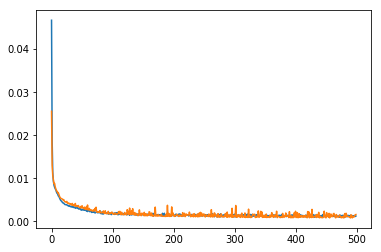

In [185]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

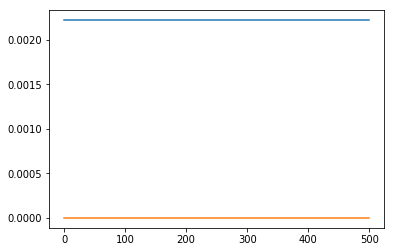

In [186]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

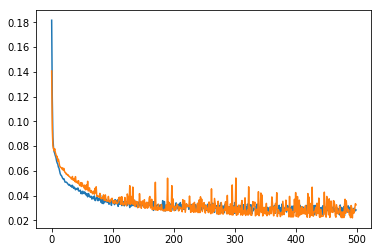

In [187]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [188]:
i = 1
y_train[i]

0.20305669507618945

In [189]:
encoder_model.predict(x_train[:10])[i]

array([0.22678709], dtype=float32)

In [190]:
i = y_train.argmin()
y_train[i:i+2]

array([0.        , 0.63992967])

In [191]:
encoder_model.predict([x_train[i:i+2]])

array([[0.08307985],
       [0.6423924 ]], dtype=float32)

## Decoder
mapping: f -> sin(f)

In [192]:
from keras.utils.generic_utils import get_custom_objects

In [193]:
# saw = Lambda(lambda x: x % 1) # No gradient defined for operation 'mod' (op type: FloorMod)
def saw(x):
     # No gradient defined for operation 'mod' (op type: FloorMod)
    # return x % 1
    
#     return K.tf.where(x < 1, x, K.zeros_like(x))
    return K.tf.where(x < 1, x, x - 1)

def sawDescending(x):
     # No gradient defined for operation 'mod' (op type: FloorMod)
    # return x % 1
#     return K.tf.where(x > 0, x, K.ones_like(x))
    return K.tf.where(x > 0, x, x + 1)

get_custom_objects().update({'saw': Activation(saw), 'sawDescending': Activation(sawDescending)})

# make sure to import this function when loading this model in another module

In [194]:
# # saw = Lambda(lambda x: x % 1) # No gradient defined for operation 'mod' (op type: FloorMod)
# def saw(x):
#      # No gradient defined for operation 'mod' (op type: FloorMod)
#     # return x % 1
#     return K.tf.where(x < 1, x, x - 1)

# def sawDescending(x):
#      # No gradient defined for operation 'mod' (op type: FloorMod)
#     # return x % 1
#     return K.tf.where(x < 0, K.ones_like(x), x)

# get_custom_objects().update({'saw': Activation(saw), 'sawDescending': Activation(sawDescending)})

# # make sure to import this function when loading this model in another module

In [213]:
decoder_input = Input(shape=(notes,))
x = decoder_input

unroll = False

ratio = 0.1
sub_t = int(timesteps * ratio)
super_t = int(timesteps/ sub_t)

# a = ELU(alpha=0.5)
# ThresholdedReLU
# PReLU
# ELU
# LeakyRelu

# x1 = starting value
# x2 :: [decay1, decay2, decay3]
# end of sequence = decay3 * (decay2 * (decay1 * x1))
# full sequence = [decay1 * x1, decay2(decay1 * x1), etc... ]

# x1 might have abias of zero
# TODO x1 ** 0.5
# x2 might disregard its input
# TODO check if x2 can have an offset bias

# decay is non-linear?
# decay = 1/f

width = 2
dims = notes * channels * width
dim1, dim2 = timesteps, 16


x1 = x
x1 = Dense(dims, activation='relu')(x1) # phase (linear)
x1 = RepeatVector(1)(x1)

x2 = x
x2 = Dense(dims, activation='relu')(x2) # e.g decay: 0.5 * decay, 0.5 * decay * decay
x2 = Dense(dims, activation='relu')(x2)
# x2 = RepeatVector(timesteps)(x2)
x2 = Dense(dim1*dim2)(x2)
x2 = Reshape([dim1, dim2])(x2)
x = SimpleRNN(dims, activation='sawDescending', return_sequences=True, unroll=unroll)(x2)

# # SimpleRNN returns 2 states, LSTM returns 3 states
# _, state = SimpleRNN(dims, return_state=True)(x1)
# rnn = SimpleRNN(dims, activation='sawDescending', return_sequences=True, unroll=unroll)
# # rnn = SimpleRNN(notes, return_sequences=True)
# # x = rnn(x2, initial_state=x1) # shape error
# x = rnn(x2, initial_state=state)

# Final layer(s)
filters = 6
kernel_size = (1,2) # (2,1)

# Conv Transpose
# x = Reshape((timesteps, notes, width))(x)
# x = Conv2DTranspose(filters, kernel_size, strides=(1,1), activation='relu', padding='same')(x)
# x = Conv2D(1, kernel_size, strides=(1,1), activation='sigmoid', padding='same')(x)

# x = Conv1D(1, kernel_size=1, strides=1, activation='sigmoid', padding='same')(x)
x = Flatten()(x)
x = Dense(np.prod(input_shape), activation='relu')(x)
x = Activation('sigmoid')(x)
x = Reshape(input_shape)(x)

decoder_output = x

decoder_model = Model(decoder_input, decoder_output, name='decoder-')
decoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_63 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_64 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_65 (Dense)             (None, 256)               768       
_________________________________________________________________
reshape_25 (Reshape)         (None, 8, 32)             0         
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 8, 2)              70        
_________________________________________________________________
flatten_8 (Flatten)          (None, 16)                0         
__________

In [214]:
ae = Model(decoder_input, encoder_model(decoder_model(decoder_input)))
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
decoder- (Model)             (None, 40, 1, 1)          1528      
_________________________________________________________________
encoder- (Model)             (None, 1)                 49        
Total params: 1,577
Trainable params: 1,528
Non-trainable params: 49
_________________________________________________________________


In [215]:
encoder_model.trainable = False

In [216]:
loss = 'mse' # mse mae binary_crossentropy rmsprop adadelta hinge
ae.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','mse'])

In [217]:
batch_size = 100
epochs = 60

In [218]:
j = -1
history = ae.fit(y_train[:j], y_train[:j], 
    epochs=epochs, batch_size=batch_size, 
    validation_data=(y_test, y_test))

Train on 899 samples, validate on 100 samples
Epoch 1/60
899/899 [==============================] - 2s 3ms/step - loss: 0.2858 - acc: 0.0000e+00 - mean_absolute_error: 0.4852 - mean_squared_error: 0.2858 - val_loss: 0.3079 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.5041 - val_mean_squared_error: 0.3079
Epoch 2/60
899/899 [==============================] - 0s 116us/step - loss: 0.2858 - acc: 0.0000e+00 - mean_absolute_error: 0.4852 - mean_squared_error: 0.2858 - val_loss: 0.3079 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.5041 - val_mean_squared_error: 0.3079
Epoch 3/60
899/899 [==============================] - 0s 82us/step - loss: 0.2858 - acc: 0.0000e+00 - mean_absolute_error: 0.4852 - mean_squared_error: 0.2858 - val_loss: 0.3079 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.5041 - val_mean_squared_error: 0.3079
Epoch 4/60
899/899 [==============================] - 0s 76us/step - loss: 0.2858 - acc: 0.0000e+00 - mean_absolute_error: 0.4852 - mean_squared_error: 0

899/899 [==============================] - 0s 76us/step - loss: 0.2858 - acc: 0.0000e+00 - mean_absolute_error: 0.4852 - mean_squared_error: 0.2858 - val_loss: 0.3079 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.5041 - val_mean_squared_error: 0.3079
Epoch 32/60
899/899 [==============================] - 0s 90us/step - loss: 0.2858 - acc: 0.0000e+00 - mean_absolute_error: 0.4852 - mean_squared_error: 0.2858 - val_loss: 0.3079 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.5041 - val_mean_squared_error: 0.3079
Epoch 33/60
899/899 [==============================] - 0s 79us/step - loss: 0.2858 - acc: 0.0000e+00 - mean_absolute_error: 0.4852 - mean_squared_error: 0.2858 - val_loss: 0.3079 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.5041 - val_mean_squared_error: 0.3079
Epoch 34/60
899/899 [==============================] - 0s 81us/step - loss: 0.2858 - acc: 0.0000e+00 - mean_absolute_error: 0.4852 - mean_squared_error: 0.2858 - val_loss: 0.3079 - val_acc: 0.0000e+00 - val_m

In [219]:
# y_train[:j]

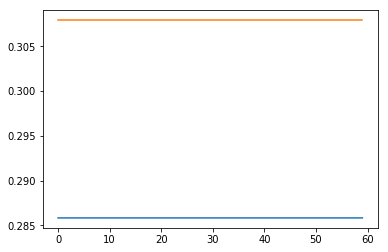

In [220]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

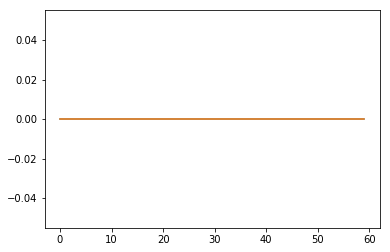

In [221]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

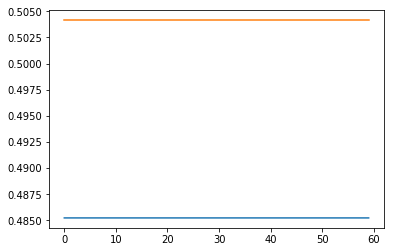

In [222]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [223]:
y_train[:10]

array([0.0975229 , 0.2030567 , 0.66029896, 0.73499663, 0.79234716,
       0.50312202, 0.57496451, 0.59133544, 0.64157082, 0.77727858])

In [224]:
f = [0.1, 0.429, 0.856, 1.4]
y = ae.predict(f)
y

array([[0.88848144],
       [0.88848144],
       [0.88848144],
       [0.88848144]], dtype=float32)

In [225]:
y_train[y_train.argmax()]

0.7998534611385836

In [226]:
y_train[y_train.argmin()]

0.0

m (40, 1)


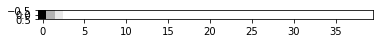

m (40, 1)


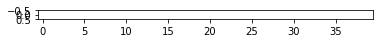

array([0.0975229, 0.2030567])

In [227]:
f = y_train[:10]
y = decoder_model.predict(f)
plot.single(x_train[0,:50,0])
plot.single(y[0,:50,0])
# plot.single(x_train[1,:50,0])
f[:2]

m (40, 1)


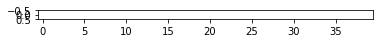

m (40, 1)


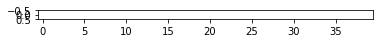

m (40, 1)


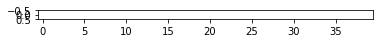

m (40, 1)


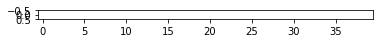

In [228]:
f = [0, 0.3, 0.6, 1.2]
y = decoder_model.predict(f)
plot.single(y[0,:50,0])
plot.single(y[1,:50,0])
plot.single(y[2,:50,0])
plot.single(y[3,:50,0])

m (40, 1)


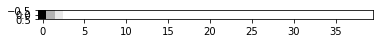

m (40, 1)


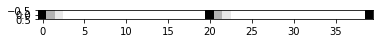

m (40, 1)


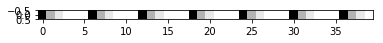

m (40, 1)


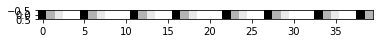

In [229]:
# goal examples
plot.single(x_train[0,:50,0])
plot.single(x_train[1,:50,0])
plot.single(x_train[2,:50,0])
plot.single(x_train[3,:50,0])

In [230]:
y_train[:5]

array([0.0975229 , 0.2030567 , 0.66029896, 0.73499663, 0.79234716])